In [1]:
# from IPython.display import HTML

# HTML('''<script>
# code_show=true;
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# }
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()">
# <input type="submit" value="Click here to toggle on/off the raw code.">
# </form>''')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
import time
pd.set_option('display.max_colwidth', None)

# Trust in Law Enforcement: Understanding the Drivers of Police Sentiment Scores

###  **1.0 Highlights**

- The overall intent of this research is to understand the drivers of police sentiment scores.
- Many datasets were used, covering geography, race, socio-economics, crime, and even public health.
- In a previous study, different regressor models were used to predict survey scores measuring trust in law enforcement. Random Forest was found to have good accuracy (together with Gradient Boosting Method) as well as good runtimes.
- This study focuses on using model interpretability methods to better provide transparency on the tuned Random Forest model.
- TreeInterpreter was studies and applied as a method for model interpretability. It provides measures of the contributions of individual features, as well as combinations of features (representing different paths along a decision tree).
- The different interpretability methods generally agree that top predictors include:
    - mortality rates from homicide
    - % black population
    - % white population
    - % households living below poverty
    - % of vacant housing units
    - crime density

### **2.0 Introduction and Motivation for the Study**

Much attention has been brought to the issue of police trust in America, with controversies surrounding the Black Lives Matter movement and police brutality. However this issue is not only relevant in the US--many other countries need guidance for their law enforcement on how to build trust and rapport within their communities.

This study explores this topic, by expanding on previous research conducted wherein different machine learning models were built to predict the degree to which a community trusts their police force. The data focuses on community areas in the city of Chicago, wherein surveys were issued to gauge whether residents feel that their local law enforcement treats them with consideration and respect. 

In the previous study, a Random Forest model was found to have nearly the highest test accuracy. Its performance was almost that of the Gradient Boosting Method but with only one-third of the runtime. This study focuses on model interpretability for the tuned Random Forest model, to provide transparency on what is generally deemed a "black-box" type of machine learning model.

Ultimately, the study seeks to provide insights on which elements in a community leads to greater trust in police. Is it crime rates? Per capita wealth? How about the proportion of racial minorities? Since the use case relates to sensitive social issues relating to income gaps and racism, more than simply building an accurate model, it was deemed important to maximize model interpretability, to yield useful insights and improve stakeholder acceptance.

### **3.0 Data Cleaning and Pre-Processing**

As with any machine learning project, one of the first steps is to gather and consolidate the data. For this particular study, multiple datasets were downloaded, many of them from the Chicago Data Portal, then examined and cleaned one by one.

*(Note: Some slight changes in the feature engineering were adopted in the study as compared to the previous study on which this was based, hence the model results may not be identical.)*

**Socio-economic Data**

First, we load a socio-economic dataset. Fortunately, there are no null values and the data requires relatively little cleaning. We need only convert the column headers to titlecase for aesthetic purposes and consistency with other datasets.

In [3]:
# Load socioeconomic data
df_socio = pd.read_csv('Features - socioeconomic.csv')

# Convert column headers to titlecase
df_socio.columns = df_socio.columns.str.title()

df_socio.head()

,Community_Area_Number,Community_Area_Name,Percent Of Housing Crowded,Percent Households Below Poverty,Percent Aged 16+ Unemployed,Percent Aged 25+ Without High School Diploma,Percent Aged Under 18 Or Over 64,Per_Capita_Income,Hardship_Index
0,1,Rogers Park,7.7,23.6,8.7,18.2,27.5,23939,39
1,2,West Ridge,7.8,17.2,8.8,20.8,38.5,23040,46
2,3,Uptown,3.8,24.0,8.9,11.8,22.2,35787,20
3,4,Lincoln Square,3.4,10.9,8.2,13.4,25.5,37524,17
4,5,North Center,0.3,7.5,5.2,4.5,26.2,57123,6


**Geographic Data**

Next, we load geographic data. Once more, it was found that minimal cleaning is required.

In [4]:
# Load geographic data
df_geog = pd.read_csv('Features - geographic.csv')

# Drop latitude and longitude, but retain Area_Sqkm for later use in feature engineering
df_geog = df_geog.drop(['Latitude', 'Longitude'], axis=1)

# Convert column headers to titlecase
df_geog.columns = df_geog.columns.str.title()

df_geog.head()

,Community_Area_Number,Community_Area_Name,Area_Sqkm
0,1,Rogers Park,4.77
1,2,West Ridge,9.14
2,3,Uptown,6.01
3,4,Lincoln Square,6.63
4,5,North Center,5.31


**Demographic Data**

Next, we load demographic data, consisting primarily of data on population count per racial group, and housing statistics.

There are no missing values to be imputed, and all the data aside from the community names appear to be numerical. However, closer observation shows that the the dataset features total population counts per racial group, as well as the total number of occupied versus vacant housing units. These are normalized accordingly based on total population and total housing units. This is because clearly a large community will always have more people belonging to each minority group, and more housing units as well.

As for the total population count and total housing unit count, these are normalized in terms of land area to obtain population and housing density.

In [5]:
# Load demographic data on ethnicity and housing
df_demog = pd.read_csv('Features - ethnicity and housing.csv')

# Convert column headers to titlecase
df_demog.columns = df_demog.columns.str.title()

# Express population counts per segment (per housing type and ethnicity)
# as proportions of total population
df_demog.iloc[:, 3:10] = df_demog.iloc[:, 3:10].to_numpy() / df_demog[['Pop_Total']].to_numpy()

# Express housing type counts as proportion of total housing units
df_demog.iloc[:, 11:13] = df_demog.iloc[:, 11:13].to_numpy() / df_demog[['Housing_Units']].to_numpy()

# Drop columns column on occupied housing units, since it is perfectly
# negatively correlated related to vacant housing units
df_demog = df_demog.drop(['Hu_Occupied'], axis=1)

# Drop columns column on population living in households, since it is perfectly
# negatively correlated to the population living in group quarters
df_demog = df_demog.drop(['Pop_Households'], axis=1)

# Normalize  features in relation to land area
df_demog['Pop_density'] = df_demog['Pop_Total'] / df_geog['Area_Sqkm']
df_demog['Hu_density'] = df_demog['Housing_Units'] / df_geog['Area_Sqkm']
df_demog = df_demog.drop('Housing_Units', axis=1)
# df_geog = df_geog.drop('Area_Sqkm', axis=1)

df_demog.head()

,Community_Area_Number,Community_Area_Name,Pop_Total,Pop_Groupquarters,Pop_Hispanic,Pop_White,Pop_Black,Pop_Asian,Pop_Other,Hu_Vacant,Ave_Household_Size,Pop_density,Hu_density
0,1,Rogers Park,55628,0.060869,0.226271,0.400733,0.248418,0.068670,0.055907,0.074621,1.978714,11662.054507,5981.341719
1,2,West Ridge,77122,0.020630,0.198478,0.365810,0.135940,0.256931,0.042841,0.062161,2.850980,8437.855580,3090.700219
2,3,Uptown,57182,0.036725,0.132682,0.522385,0.188871,0.108111,0.047952,0.080071,1.709825,9514.475874,5826.788686
3,4,Lincoln Square,40494,0.012965,0.174569,0.625821,0.039537,0.111523,0.048550,0.063041,2.087917,6107.692308,3081.598793
4,5,North Center,35114,0.001595,0.128239,0.734721,0.022213,0.061571,0.053255,0.063065,2.348001,6612.806026,3001.129944


**Crime Data**

Next, we load data on crime reports. Here, the data is much more vast, listing a year's worth of crime reports. Hence we discard unnecessary columns and aggregate the statistics in terms of the 2020 reported crime count per Community Area. Crime count is normalized based on total population, to obtain crime density.

In [6]:
# Load crime data
df_crime = pd.read_csv('Features - crime 2020.csv')

# Retrieve only crime count per community area
df_crime = df_crime.groupby('Community Area')[['ID']].count().reset_index()

# Rename columns
df_crime.columns = ['Community_Area_Number', 'Crimes']

# Convert Community Area column to integer type
df_crime['Community_Area_Number'] = df_crime['Community_Area_Number'].astype(int)

# Normalize in relation to total population
df_crime['Crime_density'] = df_crime['Crimes'] / df_demog['Pop_Total']
df_crime = df_crime.drop('Crimes', axis=1)

# Drop Pop_Total since crime density had already been computed earlier.
df_demog = df_demog.drop('Pop_Total', axis=1)

df_crime.head()

,Community_Area_Number,Crime_density
0,1,0.058945
1,2,0.040053
2,3,0.051345
3,4,0.046402
4,5,0.032694


**Public Health Data**

Finally, we load the public health indicators. Here we can see that there are numerous features, a number of them redundant with socio-economic data loaded previously. Also, many of the features are unlikely to have any relevance to the topic at hand; for instance the infection rates of gonnerhea in females would very likely have no bearing on police sentiment scores (any correlation would likely be spurious, and certainly uninterpretable). Hence we drop these columns, including those with missing values. We apply our judgement and perform feature selection, retaining only data on overall birth rates, teen birth/pregnancy rates, and mortality rates related to assault and firearms.

In [7]:
# Load public health data
df_health = pd.read_csv('Features - public health.csv')

# Perform feature engineering by retaining only columns that 
# may have possible relevance to police sentiment scores. Exclude
# also columns that are redundant with previously loaded socio-economic data.
df_health = df_health[['Community_Area_Number', 'Community_Area_Name',
                       'Birth Rate', 'Nat_Teen Birth Rate',
                       'Mort_Assault (Homicide)', 'Mort_Firearm-related']]
df_health.head()

,Community_Area_Number,Community_Area_Name,Birth Rate,Nat_Teen Birth Rate,Mort_Assault (Homicide),Mort_Firearm-related
0,1,Rogers Park,16.4,40.8,7.7,5.2
1,2,West Ridge,17.3,29.9,5.8,3.7
2,3,Uptown,13.1,35.1,5.4,4.6
3,4,Lincoln Square,17.1,38.4,5.0,6.1
4,5,North Center,22.4,8.4,1.0,1.0


**Data Consolidation**

Finally, we consolidate all the disparate datasets into one design matrix, and set the Community Area Name and Number as the index.

In [8]:
# Put all the data together in one design matrix

df_all = df_geog.copy()
df_all = df_all.merge(df_socio.drop('Community_Area_Name', axis=1),
                      on='Community_Area_Number')
df_all = df_all.merge(df_crime, on='Community_Area_Number')
df_all = df_all.merge(df_demog.drop('Community_Area_Name', axis=1),
                      on='Community_Area_Number')
df_all = df_all.merge(df_health.drop('Community_Area_Name', axis=1),
                      on='Community_Area_Number')
df_all = df_all.set_index(df_all['Community_Area_Number'].astype(str)
                          + ' - '
                          + df_all['Community_Area_Name'])
df_all = df_all.drop(['Community_Area_Number', 'Community_Area_Name'], axis=1)


df_all

,Area_Sqkm,Percent Of Housing Crowded,Percent Households Below Poverty,Percent Aged 16+ Unemployed,Percent Aged 25+ Without High School Diploma,Percent Aged Under 18 Or Over 64,Per_Capita_Income,Hardship_Index,Crime_density,Pop_Groupquarters,...,Pop_Asian,Pop_Other,Hu_Vacant,Ave_Household_Size,Pop_density,Hu_density,Birth Rate,Nat_Teen Birth Rate,Mort_Assault (Homicide),Mort_Firearm-related
1 - Rogers Park,4.77,7.7,23.6,8.7,18.2,27.5,23939,39,0.058945,0.060869,...,0.068670,0.055907,0.074621,1.978714,11662.054507,5981.341719,16.4,40.8,7.7,5.2
2 - West Ridge,9.14,7.8,17.2,8.8,20.8,38.5,23040,46,0.040053,0.020630,...,0.256931,0.042841,0.062161,2.850980,8437.855580,3090.700219,17.3,29.9,5.8,3.7
3 - Uptown,6.01,3.8,24.0,8.9,11.8,22.2,35787,20,0.051345,0.036725,...,0.108111,0.047952,0.080071,1.709825,9514.475874,5826.788686,13.1,35.1,5.4,4.6
4 - Lincoln Square,6.63,3.4,10.9,8.2,13.4,25.5,37524,17,0.046402,0.012965,...,0.111523,0.048550,0.063041,2.087917,6107.692308,3081.598793,17.1,38.4,5.0,6.1
5 - North Center,5.31,0.3,7.5,5.2,4.5,26.2,57123,6,0.032694,0.001595,...,0.061571,0.053255,0.063065,2.348001,6612.806026,3001.129944,22.4,8.4,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73 - Washington Heights,7.41,1.1,16.9,20.8,13.7,42.6,19713,48,0.105964,0.006543,...,0.001237,0.021783,0.087360,2.610715,3382.591093,1410.391363,12.0,65.0,38.0,35.6
74 - Mount Greenwood,7.02,1.0,3.4,8.7,4.3,36.8,34381,16,0.027593,0.018682,...,0.006227,0.027324,0.061387,2.668613,2653.561254,1039.601140,12.5,7.7,2.2,7.4
75 - Morgan Park,8.55,0.8,13.2,15.0,10.8,40.3,27149,30,0.079345,0.025961,...,0.003446,0.031247,0.077834,2.524281,2477.894737,1036.842105,13.2,46.7,19.9,15.8
76 - O'Hare,34.55,3.6,15.4,7.1,10.9,30.3,25828,24,0.090326,0.000820,...,0.145923,0.030481,0.061280,2.177168,388.364689,189.869754,15.8,15.9,5.6,11.8


As good practice, we compute descriptive statistics on the dataset.

In [9]:
# Summarize the data
df_all.describe()

,Area_Sqkm,Percent Of Housing Crowded,Percent Households Below Poverty,Percent Aged 16+ Unemployed,Percent Aged 25+ Without High School Diploma,Percent Aged Under 18 Or Over 64,Per_Capita_Income,Hardship_Index,Crime_density,Pop_Groupquarters,...,Pop_Asian,Pop_Other,Hu_Vacant,Ave_Household_Size,Pop_density,Hu_density,Birth Rate,Nat_Teen Birth Rate,Mort_Assault (Homicide),Mort_Firearm-related
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,...,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,7.763766,4.923377,21.766234,15.372727,20.341558,35.746753,25563.168831,49.506494,0.086040,0.014191,...,0.065467,0.029328,0.094825,2.527401,5114.473040,2395.280590,15.698701,50.064935,18.068831,16.731169
std,5.108717,3.682887,11.529957,7.543412,11.823152,7.327716,15293.098259,28.690556,0.058442,0.022040,...,0.110733,0.013126,0.044187,0.489419,2868.209954,1824.133629,3.528735,28.097817,16.561077,14.462222
min,1.500000,0.300000,3.300000,4.700000,2.500000,13.500000,8201.000000,1.000000,0.023167,0.000000,...,0.000794,0.005941,0.034383,1.556212,388.364689,189.869754,9.400000,1.300000,0.000000,1.000000
25%,4.610000,2.300000,13.200000,9.200000,11.800000,32.000000,15754.000000,25.000000,0.042087,0.001682,...,0.002885,0.020046,0.062161,2.186270,3156.069364,1329.359823,12.900000,33.700000,4.900000,5.500000
50%,7.410000,3.800000,18.900000,13.900000,18.500000,38.100000,21323.000000,50.000000,0.058945,0.005719,...,0.020969,0.026564,0.085273,2.501150,4532.666667,1910.526316,15.700000,49.200000,10.800000,10.600000
75%,9.190000,6.800000,29.200000,20.000000,26.600000,40.500000,28887.000000,74.000000,0.122182,0.016142,...,0.080920,0.038321,0.122628,2.785216,6399.573864,2753.068592,18.500000,67.900000,32.200000,25.800000
max,34.550000,15.800000,56.500000,35.900000,54.800000,51.500000,88669.000000,98.000000,0.284059,0.098486,...,0.722318,0.061753,0.239902,3.816092,14856.478873,10905.492958,22.400000,116.900000,70.300000,70.300000


**Feature Scaling**

No scaling will be performed since only Decision Tree-based models will be used, and such models are scale-invariant.

**Target Data: Police Sentiment Scores**

Having gathered the data related to the predictor variables, we still need to put together the data for the target variable. Hence we load data on police sentiment scores.  We see again that minimal cleaning is needed. One column, the Police District, is redundant since we already know the Community Area, hence it may be dropped.

In [10]:
# Load target data on police sentiment scores
df_targets = pd.read_csv('Target - Police sentiment.csv')

# Convert column headers to titlecase
df_targets.columns = df_targets.columns.str.title()

# Drop redundant column
df_targets = df_targets.drop('Police District', axis=1)

# Set index
df_targets = df_targets.set_index(df_targets['Community_Area_Number'].astype(str)
                                  + ' - '
                                  + df_targets['Community_Area_Name'])
df_targets = df_targets.drop(['Community_Area_Number', 'Community_Area_Name'], axis=1)

df_targets.head()

,Safety_Score,Trust_Score
1 - Rogers Park,63.229,64.549
2 - West Ridge,63.229,64.549
3 - Uptown,66.875,67.906
4 - Lincoln Square,67.803,66.445
5 - North Center,66.875,67.906


### **4.0 Data Exploration**

Having consolidated the data, we move on to data exploration and visualization. Since there are a lot of features to consider, we can look at the different component feature sets one by one.

First, we examine the target dataset using a pairplot and correlation heatmap. The police sentiment survey actually provides two different scores, a `Safety Score` and `Trust Score`. For this study, we are interested mainly the the Trust Score, which corresponds to how a community feels that their law enforcement are trustworthy, respectful, and concerned (the Safety Score relates to how safe an individual feels in their community). However it is interesting to see that the two scores appear highly correlated, hence the predictors for one score may also be good predictors for the other.

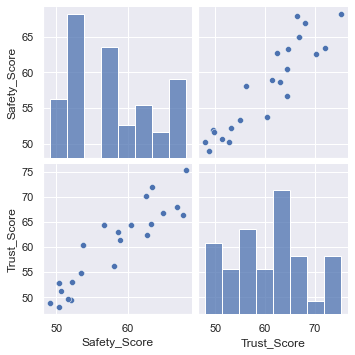

In [11]:
sns.set(style="darkgrid")
sns.pairplot(df_targets)
plt.show()

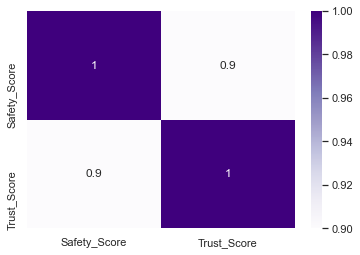

In [12]:
sns.heatmap(df_targets.corr().round(2), cmap='Purples', annot=True)
plt.show()

Next, we examine the socio-economic features using a pairplot and correlation heatmaps. We see that many of the features are indeed quite highly correlated. This stands to reason, since lower income in a community is likely to be an indicator of other socio-economic problems, such as poverty, unemployment, poor education, or overcrowding.

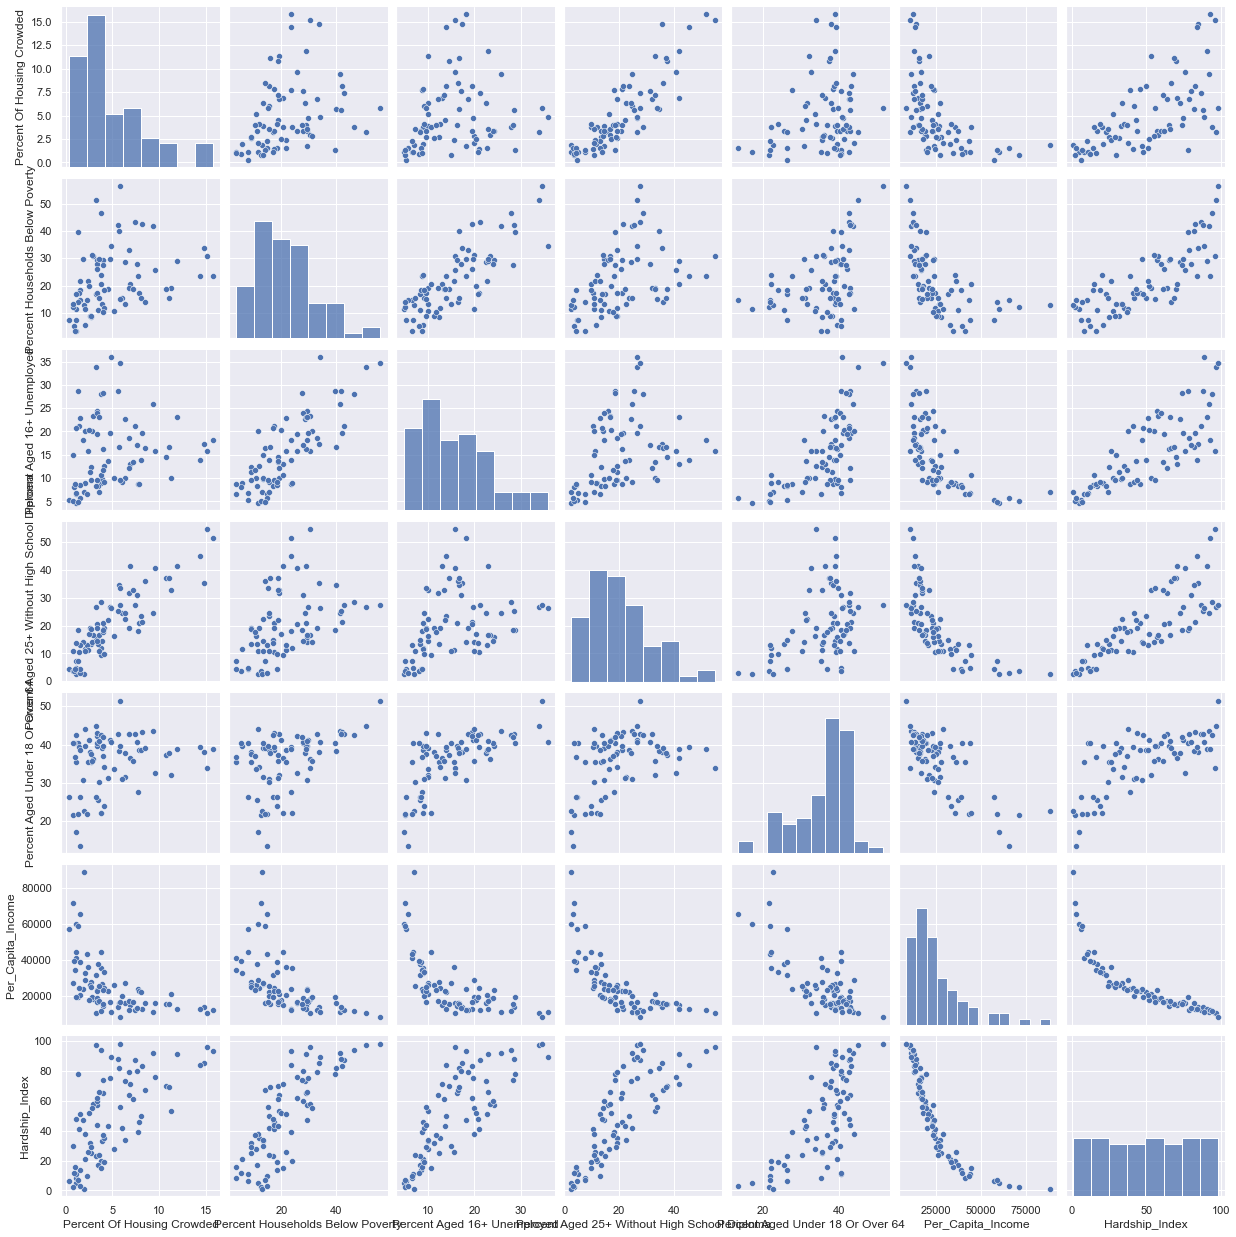

In [13]:
sns.set(style="darkgrid")
sns.pairplot(df_socio.set_index(['Community_Area_Number',
                                 'Community_Area_Name']))
plt.show()

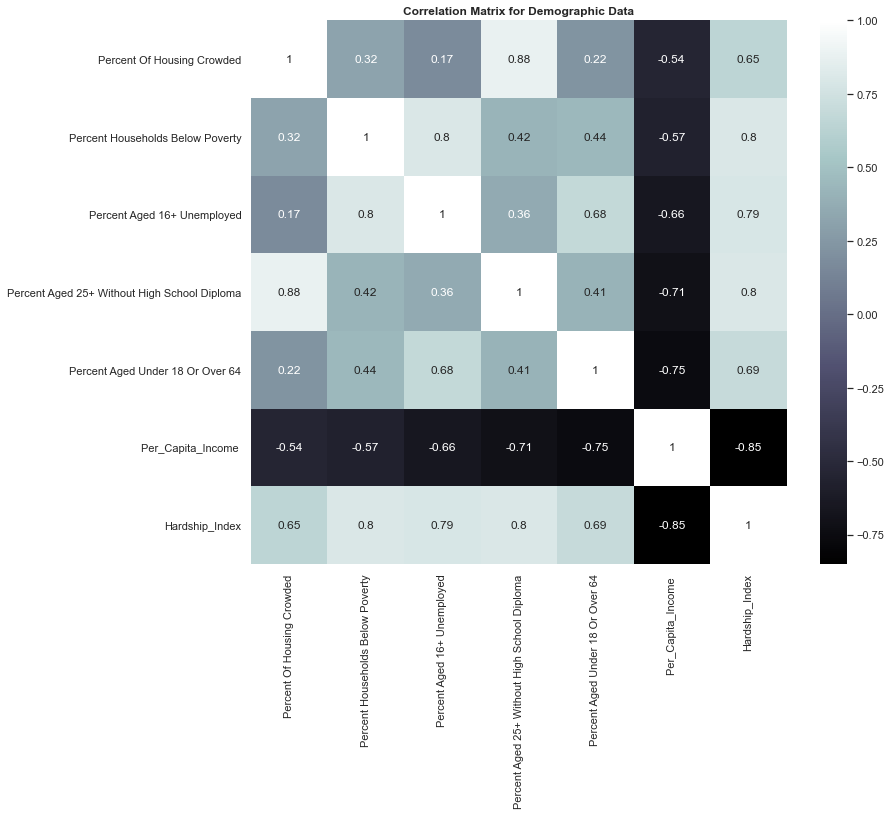

In [14]:
fig, ax = plt.subplots(figsize=(12, 10))
fig = sns.heatmap(df_socio.set_index(['Community_Area_Number',
                                      'Community_Area_Name']).
                  corr().round(2), cmap='bone', annot=True, ax=ax)
fig.set_title('Correlation Matrix for Demographic Data', weight='bold')
plt.show()

Another feature set we would like to examine more closely is the demographic data. There appear to be some interesting patterns, such as there appears to be only few Asians in Chicago in most of the Community Areas, and the Hispanic population seems to be positive colleralted with Average Household Size.

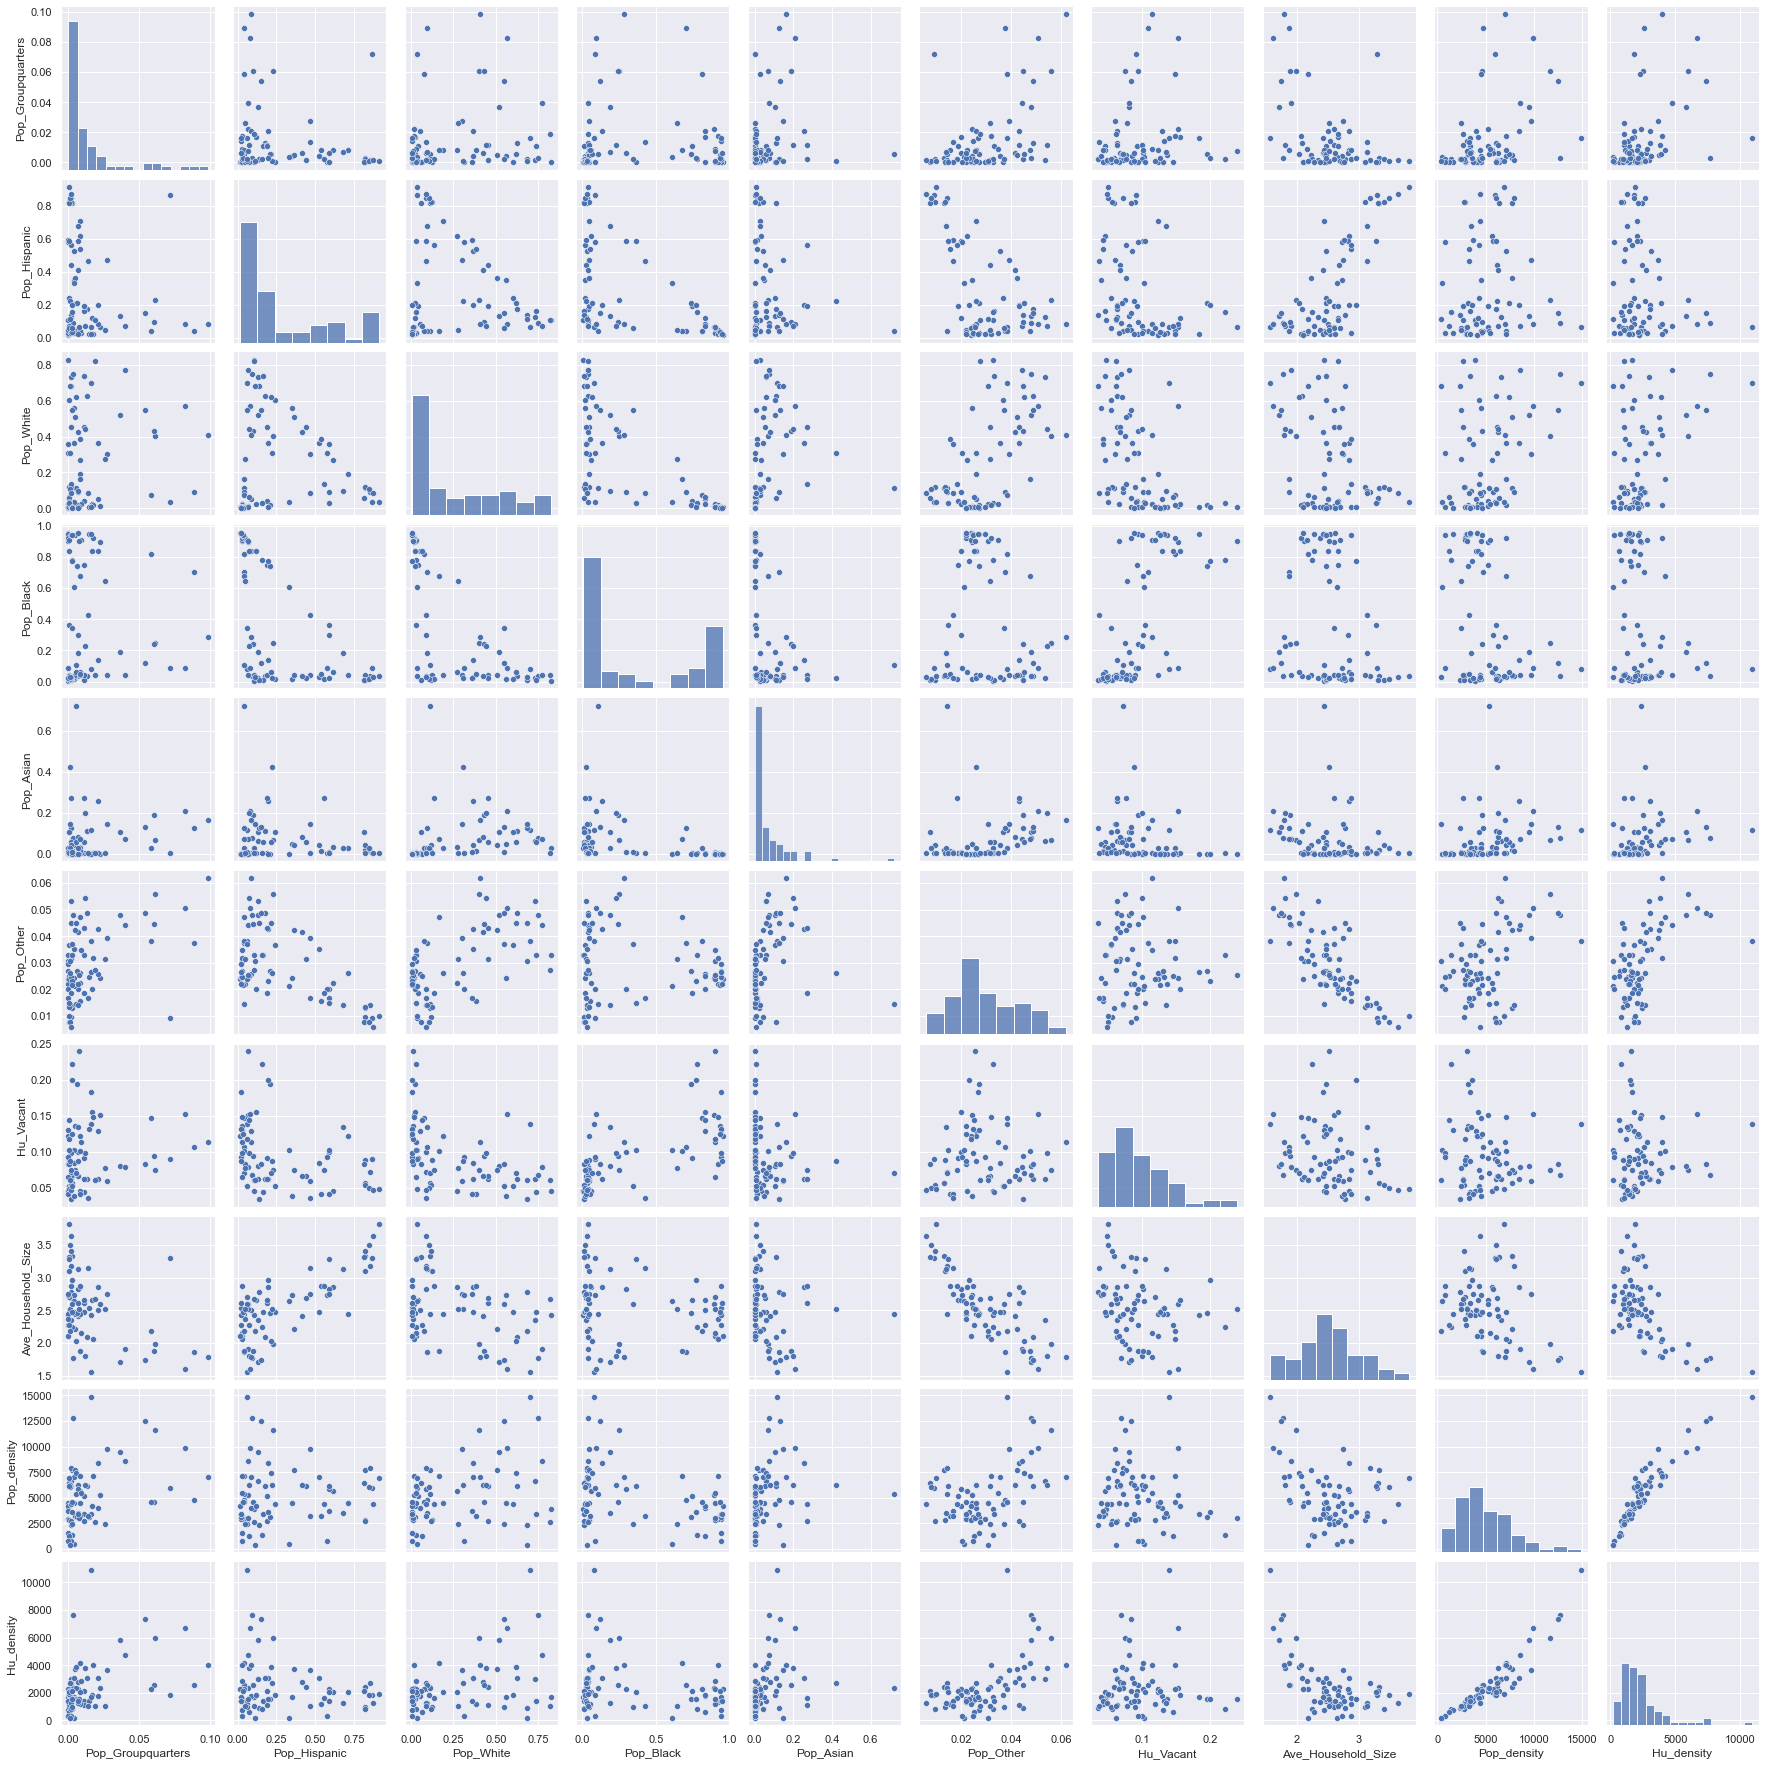

In [15]:
sns.set(style="darkgrid")
sns.pairplot(df_demog.set_index(['Community_Area_Number',
                                 'Community_Area_Name']))
plt.show()

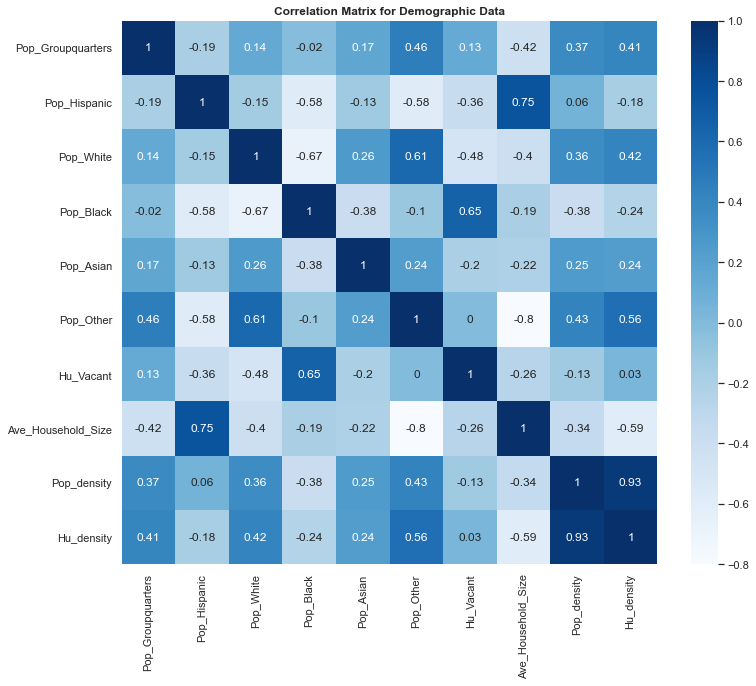

In [16]:
fig, ax = plt.subplots(figsize=(12, 10))
fig = sns.heatmap(df_demog.set_index(['Community_Area_Number',
                                      'Community_Area_Name']).
                  corr().round(2), cmap='Blues', annot=True, ax=ax)
fig.set_title('Correlation Matrix for Demographic Data', weight='bold')
plt.show()

Finally, we look at the public health data. One observation that leaps out is the very high correlation between deaths due to homicide, and deaths due to firearms, for obvious reasons.

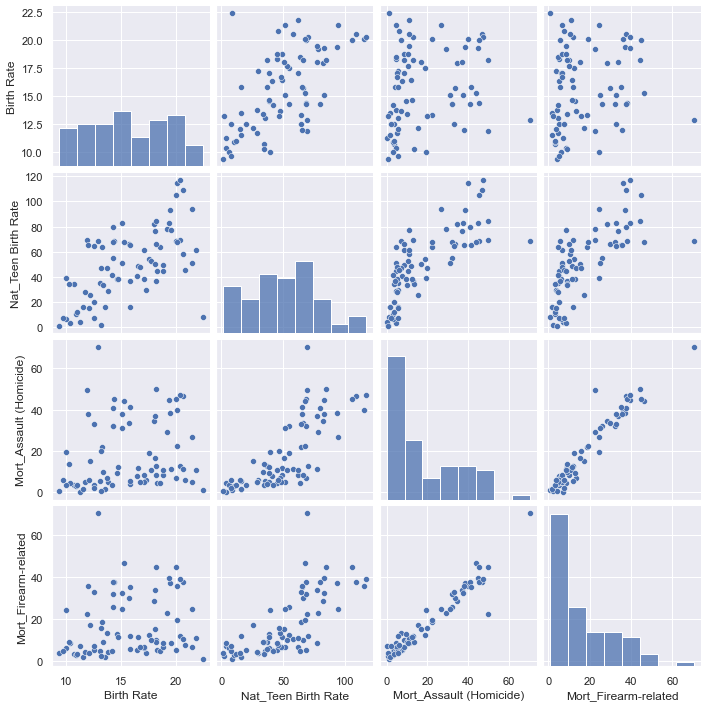

In [17]:
sns.set(style="darkgrid")
sns.pairplot(df_health.set_index(['Community_Area_Number',
                                 'Community_Area_Name']))
plt.show()

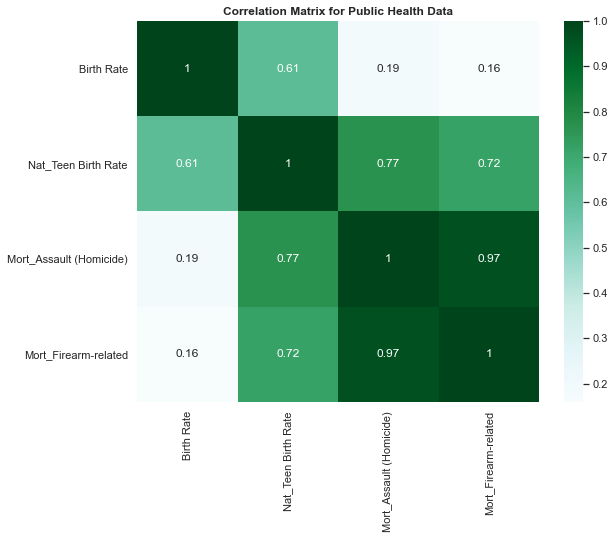

In [18]:
fig, ax = plt.subplots(figsize=(9, 7))
fig = sns.heatmap(df_health.set_index(['Community_Area_Number',
                                      'Community_Area_Name']).
                  corr().round(2), cmap='BuGn', annot=True, ax=ax)
fig.set_title('Correlation Matrix for Public Health Data', weight='bold')
plt.show()

Finally, we summarize the entire features dataset into one correlation heatmap, allowing us to view correlations between individual features across different feature sets. For instance, here we can observe that the proportion of the White population in a community is inversely related to the homicide- and firearm-related deaths.

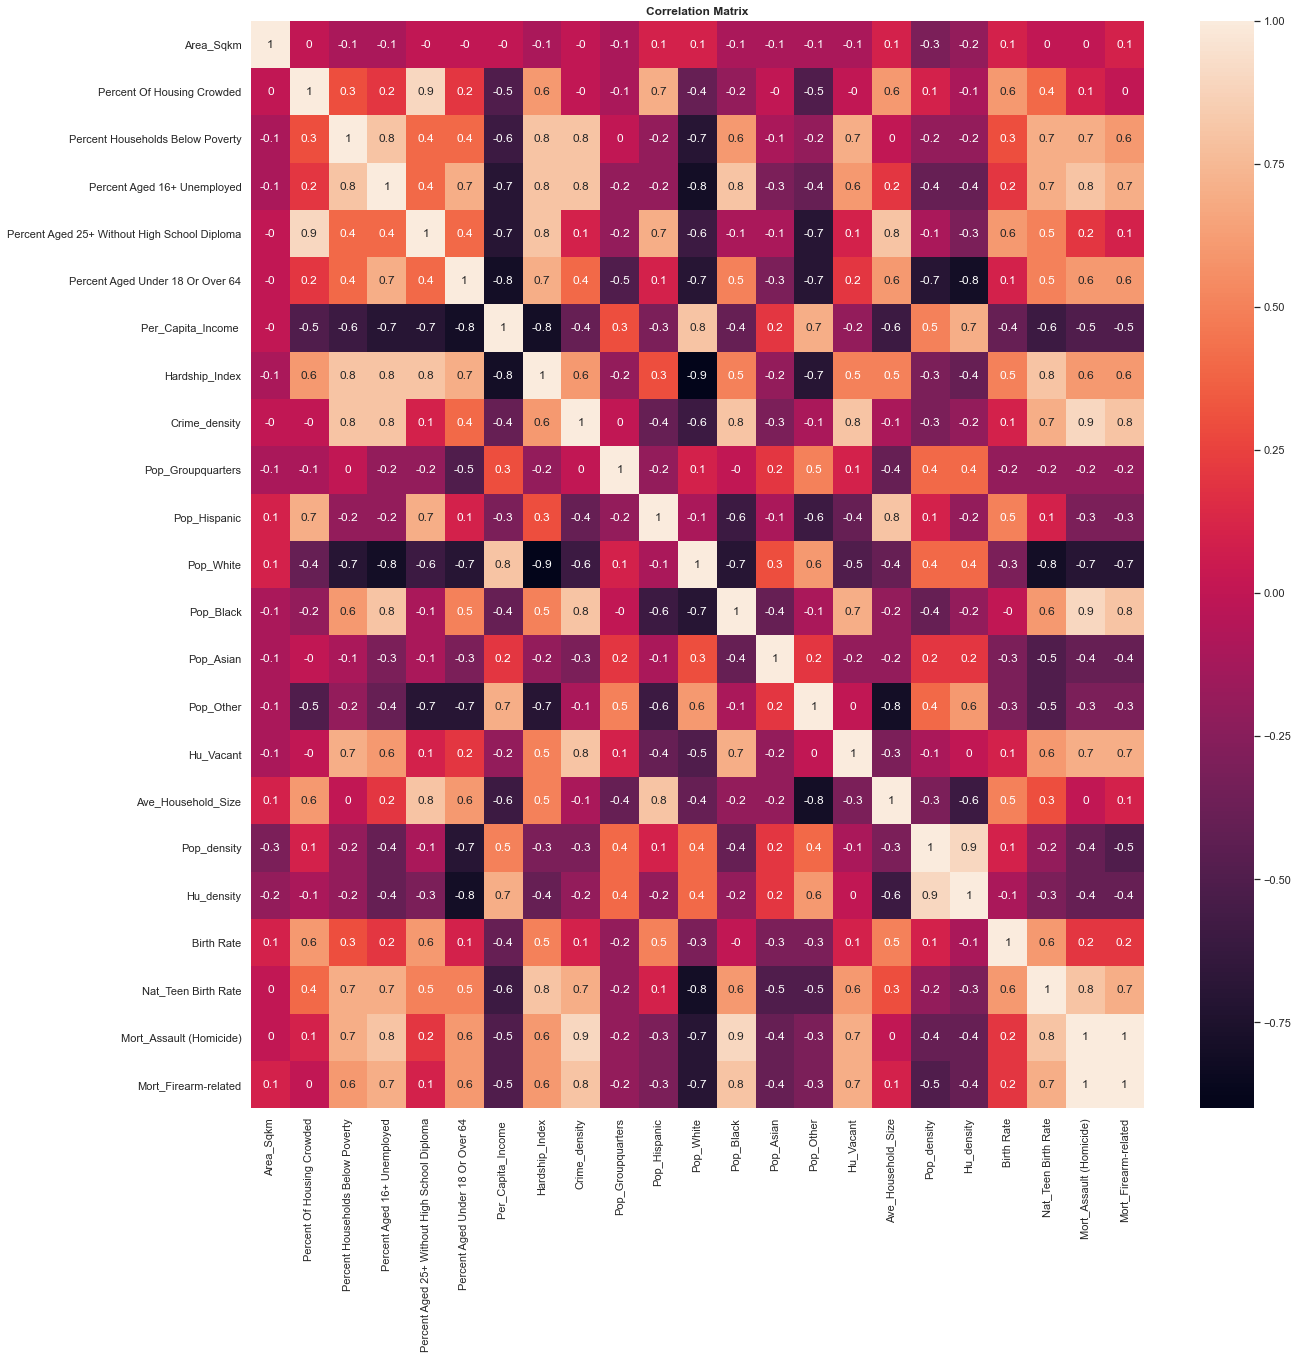

In [19]:
fig, ax = plt.subplots(figsize=(20, 20))
fig = sns.heatmap(df_all.corr().round(1), annot=True, ax=ax)
fig.set_title('Correlation Matrix', weight='bold')
plt.show()

One final consideration is whether to remove features that appear well-correlated with others. Based on trial and error, it appears that removing such features did not materially impact the accuracy of the models, and in some cases led to lower intepretability in the results. Hence the previously constructed design matrix would be kept as is.

### **5.0 Building the Model**

Finally, we proceed to tuning the hyperparameters of the Random Forest model.

- GridSearchCV is used in conjunction with a cross-validator like RepeatedKFold, simplifying the code. For RepeatedKFold, `n_splits=6` was selected based on trial-and-error, to achieve the best accuracy.
- GridSearchCV also efficiently tunes the hyperparameters and returns a handy table of the different grid search training and test scores, without the need for unwieldy for-loops
- Incidentally, the `RepeatedKFold` cross-validator was found to result in a  higher accuracy compared to `KFold`, which yielded negative test accuracy scores when using the setting `shuffle=False`.

In [20]:
X = df_all
y = df_targets['Trust_Score']
feature_names = list(df_all.columns)

In [21]:
# Random Forest

def train_RF():
    start_time = time.time()
    steps = [('RF', RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=1))]
    pipeline = Pipeline(steps)

    model = 'Random Forest'
    params = {'RF__max_depth': range(2, 10),
              'RF__max_features': ['sqrt', 'log2', 'auto']}
    cv = RepeatedKFold(n_splits=6, n_repeats=5, random_state=1)

    grid_search = GridSearchCV(pipeline, refit=True, param_grid=params,
                               cv=cv, return_train_score=True)
    grid_search.fit(X, y)

    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df = (results_df[['params', 'rank_test_score',
                              'mean_train_score', 'std_train_score',
                              'mean_test_score', 'std_test_score']])

    s_predictors = pd.Series(grid_search.best_estimator_
                             .named_steps['RF'].feature_importances_).abs()
    s_predictors.index = feature_names
    s_predictors = s_predictors.sort_values()

    results_df = results_df.sort_values(by=['rank_test_score']).reset_index(drop=True)
    top_result = results_df[:1].copy()
    top_result['params'] = top_result['params'].astype(str).str.extract(r'{(.+)}')
    top_result = top_result.rename(columns={'params': 'model_top_parameter'})
    top_result = top_result.drop(['rank_test_score'], axis=1)
    top_result['run_time'] = (time.time() - start_time)
    display(top_result)
    return top_result


RF_results = train_RF()

,model_top_parameter,mean_train_score,std_train_score,mean_test_score,std_test_score,run_time
0,"'RF__max_depth': 7, 'RF__max_features': 'sqrt'",0.957976,0.004309,0.65772,0.110276,164.159636


Having identified the best hyperparameters using cross-validation, a model is trained using the entire dataset, simulating deployment. This model will then be used for subsequent analyses on model interpretability.

In [22]:
rf_model = RandomForestRegressor(max_depth=7, max_features='sqrt',
                                 n_jobs=-1, random_state=1)
rf_model = rf_model.fit(X, y)

### **6.0 Model Interpretation**

In [23]:
from sklearn.inspection import permutation_importance
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay
from sklearn.base import clone 
import shap
shap.initjs()

pd.set_option('display.max_rows', 20)

In this section, we seek to make transparent the "black box" Random Forest model, by applying different interpretability techniques. We begin by applying model-agnostic methods for global and local interpretability, and then explore `TreeInterpreter`, a method specific to Random Forest models.

### 6.1 Model-Agnostic Methods

#### Feature Importance

The first interpretability method used is feature importance. This is perhaps the most available metric, since it is already a method of the `sklearn`'s `RandomForestRegressor` class. Also known as Gini importance, this is computed based on the mean decrease impurity for each feature, averaged across all the trees in the random forest.

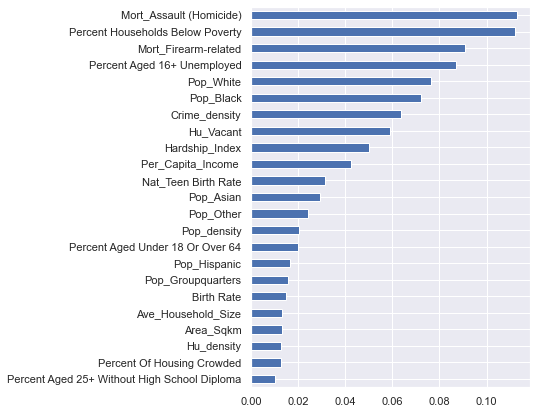

In [24]:
# Feature Importance
fig, ax = plt.subplots(figsize=(5, 7))
feat_importances = pd.Series(rf_model.feature_importances_, index=feature_names)
feat_importances.sort_values(ascending=True).plot(kind='barh')
plt.show()

#### Permutation Importance

The second interpretability method applied is Permutation Importance, which is computed by permuting or shuffling each feature and then comparing the resulting accuracy of the model against the baseline accuracy. These figures can be obtained using a module available using `sklearn`.

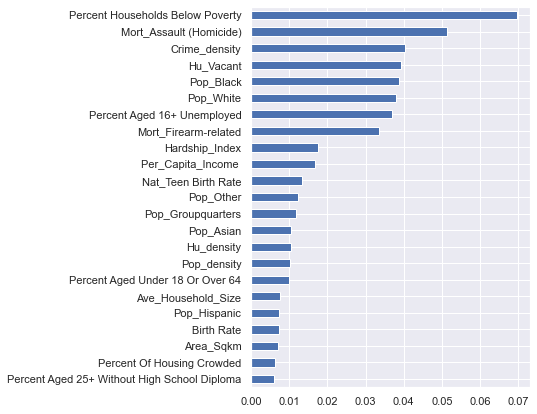

In [25]:
# Permutation Importance using sklearn
permut_importances = permutation_importance(rf_model, X, y, random_state=1).importances_mean
permut_importances = pd.Series(permut_importances, index=feature_names)
permut_importances.sort_values(ascending=True).plot(kind='barh', figsize=(5, 7))
plt.show()

For comparison's sake, permutation importance is also obtained using a more manual implementation, without availing of `sklearn.inspection.permutation_importance`. It is seen that results are highly similar. Some variation is expected since there is randomness involved when permuting features. 

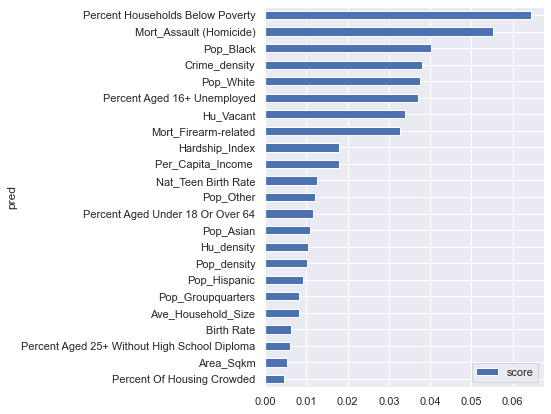

In [26]:
# Permutation Importance using manual implementation

score_full_mod = rf_model.score(X, y)
permut_scores = []

for predictor in X:
    X_copy = X.copy()
    X_copy[predictor] = X[predictor].sample(frac=1, random_state=1).values
    permut_score = rf_model.score(X_copy, y)
    permut_scores.append({'pred': predictor,
                          'score': score_full_mod - permut_score})

permut_scores_df = (pd.DataFrame(permut_scores).
                    sort_values(by='score', ascending=False).set_index('pred'))
ax = permut_scores_df.plot(kind='barh', figsize=(5, 7))
ax.invert_yaxis()

#### Shap Summary Plots

The third interpretability method applied in this study is SHAP. We start by constructing a SHAP summary plot in the form of a horizontal bar chart, for comparability with the feature importance plot and permutation important plots constructed above. It may be noted that `TreeExplainer` method was used here for efficient estimation of SHAP values, even though it is not strictly model-agnostic but rather was designed specifically for tree-based models. Still, the underlying concept behind SHAP can be applied to any machine learning model.

In [27]:
explainer = shap.TreeExplainer(rf_model, X)
shap_values = explainer(X)

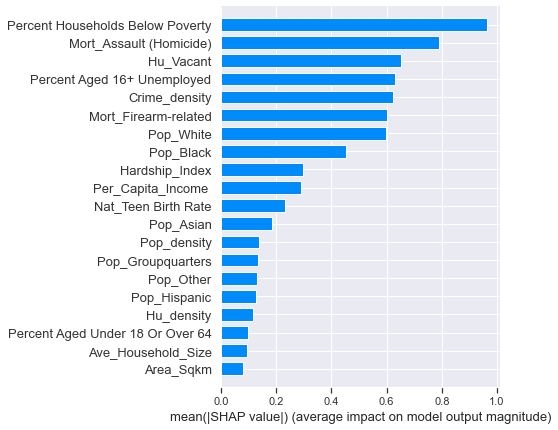

In [28]:
# Shap Summary Plots

shap.summary_plot(shap_values=shap_values, 
                  features=X, plot_type='bar', plot_size=(5, 7))

At this point, we pause and observe that the three different feature importance plots are highly similar, and largely agree on the most important features. Specifically, the top 8 predictors for trust in police are:
- Mortality rates due to homicide
- Mortality rates from firearms
- Crime density
- Percentage of households below poverty
- Percentage of adults unemployed
- Percentage of the population that are black
- Percentage of the population that are white
- Proportion of housing units that are vacant

To probe thus further, we construct some additional plots based on SHAP values, specifically the violin plot and the beeswarm plot. These are two different ways of showing the distribution of SHAP values per feature. 

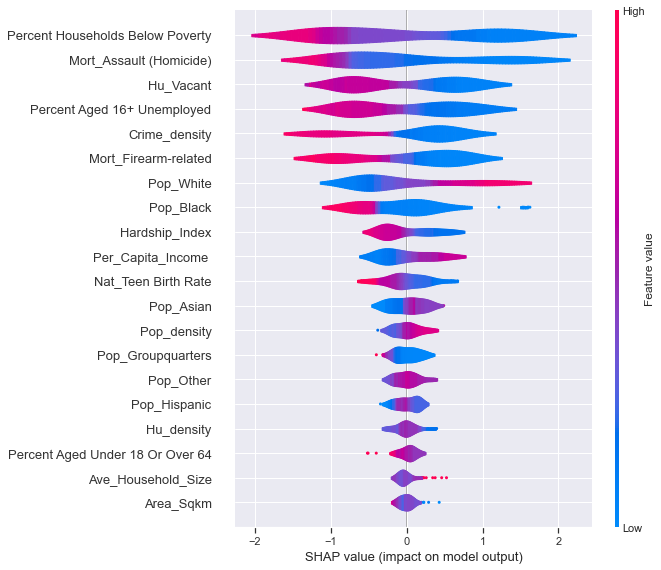

In [29]:
shap.summary_plot(shap_values=shap_values, 
                  features=X, plot_type='violin')

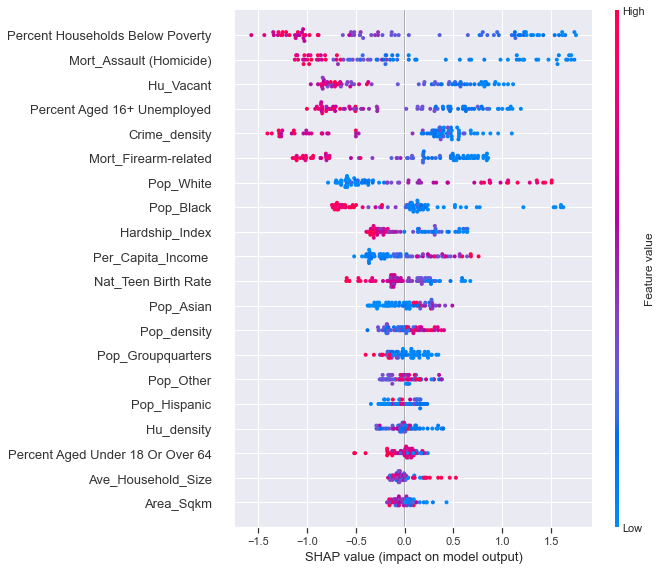

In [30]:
shap.summary_plot(shap_values=shap_values, 
                  features=X, plot_type='dot')

Offhand, some interpretations are very readily apparent, based on the pattern of colors on the plots. We can see that high values of the following features contribute *positively* to police trust scores (and vice versa):
- Mortality rates due to homicide
- Mortality rates from firearms
- Crime density
- Percentage of households below poverty
- Percentage of adults unemployed
- Percentage of the population that are black
- Proportion of housing units that are vacant

Meanwhile, high values of the following feature contributes *negatively* to the target variable:
- Percentage of the population that are white

A somewhat similar plot is the decision plot, which shows the prediction line for each observation. When viewed from the bottom of the plot upwards (thus in order of increasing feature importance based on mean SHAP value), it shows how each feature moves the prediction from the naive value.

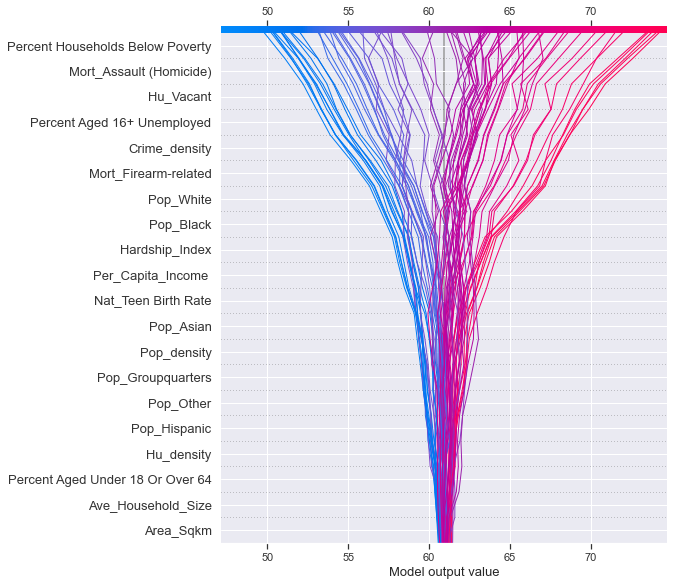

In [31]:
shap.decision_plot(base_value=explainer.expected_value, shap_values=shap_values.values, 
                  features=X)

Another plot we can utilize is the heatmap, which shows how SHAP values are distributed across features and observations. The left of the plot pertains to communities which have high trust scores (and therefore positive SHAP values), and the right side consists of instances with low police trust scores.

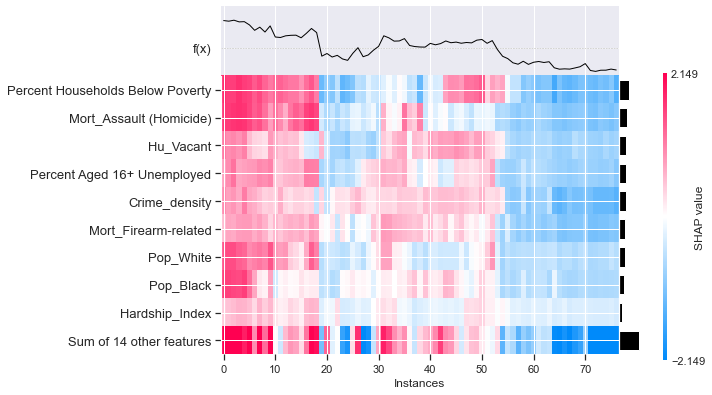

In [32]:
shap.plots.heatmap(shap_values)

Similar information is provided by constructing a force plots covering the entire dataset, showing how features "push" instances to high or low values of the target variable, respectively. The plot is interactive, and hovering the mouse cursor over the plot shows the  values of the most impactful features for the given instance.

In [33]:
shap.plots.force(explainer.expected_value, shap_values.values,
                 features=X, feature_names=feature_names)

#### Partial Dependence Plots

Next, partial dependence plots are constructed for the top 8 features, to depict exactly how differing values of a feature contributes to the target variable outcomes. The plotted lines confirms what was observed from the SHAP summary plots, in that worse socio-economic variables and higher proportions of black individuals within the population are predictors for low trust scores. Meanwhile the opposite is true for a higher proportion of white people in the population.

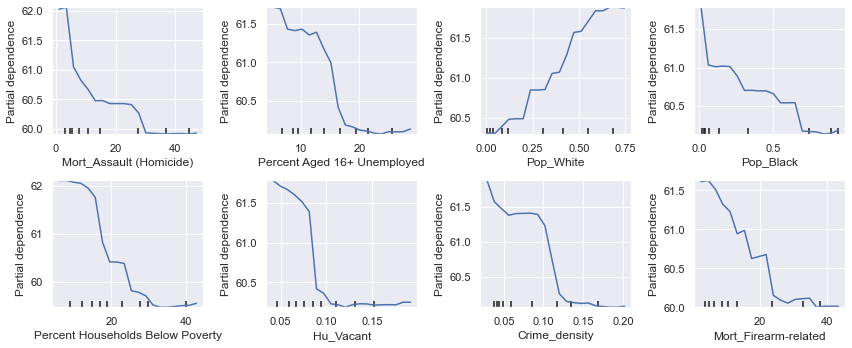

In [34]:
features = ['Mort_Assault (Homicide)', 'Percent Aged 16+ Unemployed',
            'Pop_White', 'Pop_Black', 'Percent Households Below Poverty',
            'Hu_Vacant', 'Crime_density', 'Mort_Firearm-related']

fig, ax = plt.subplots(2, 4, figsize=(12, 5))

for idx, feature_name in enumerate(features):
    PartialDependenceDisplay.from_estimator(
        estimator=rf_model,          # Estimator to be used
        X=X,                         # Data to be used for interpretation
        features=[feature_name],      # Feature list to be inspected
        feature_names=feature_names, # Feature names in the data
        kind="average",              # kind='average' refers to PDP
        n_jobs=-1,                   # Number of CPU to compute the PDP in parallel
        grid_resolution=20,          # Number of points to be used in setting the
                                     #     feature of interest
        random_state=1,              # Set random state for reproducibility
        method='brute',              # Choose method of computing PDP
        ax=ax[idx//4, idx%4]
    )

plt.tight_layout()

Dependence plots are also made using SHAP, for completeness' sake. Similar information is provided as the partial dependence aplots above; however these also show interactions between the selected (i.e. most important) features and other features. For instance, it may be observed that communities with a high proportion of white people also have good education rates (as measured by adults aged 25 and older who did not receive a high school diploma) and encounter less urban decay in their neighborhoods (as measured by the proportion of housing units that are vacant).

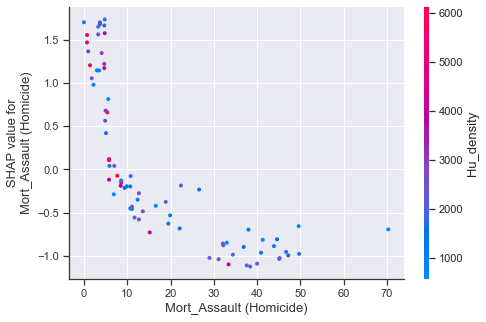

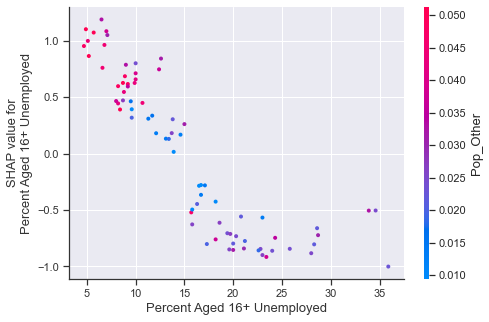

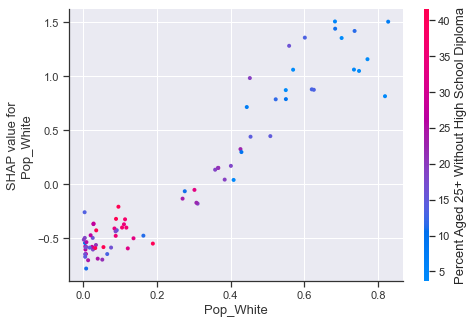

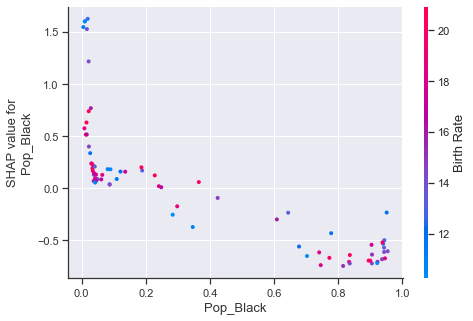

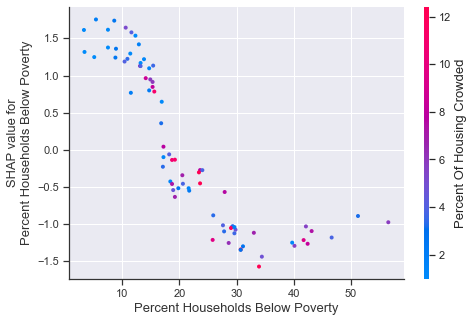

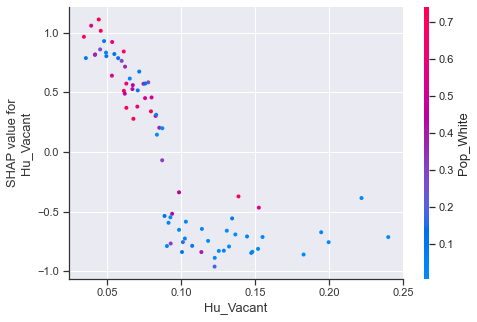

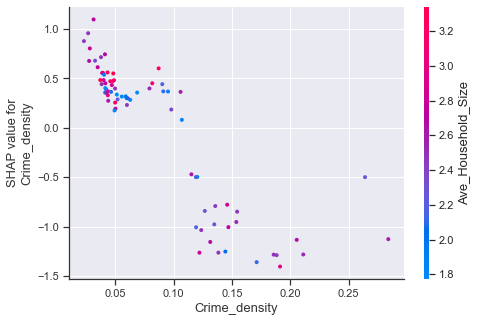

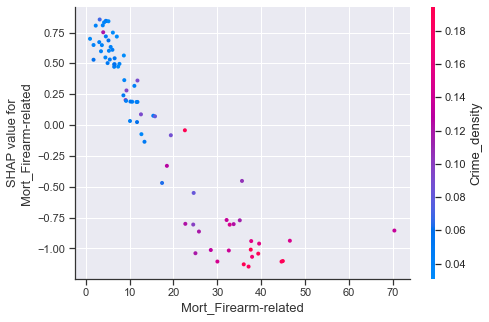

In [35]:
features = ['Mort_Assault (Homicide)', 'Percent Aged 16+ Unemployed',
            'Pop_White', 'Pop_Black', 'Percent Households Below Poverty',
            'Hu_Vacant', 'Crime_density', 'Mort_Firearm-related']

for feature in features:
    shap.dependence_plot(ind=feature, shap_values=shap_values.values, 
                         features=X)


#### Applicability of Drop Column Importance

Another model interpretability explored in this study is drop column importance, as recommended by some data science blogs. (Badeer, 2020) (Lewinson, 2019) This is computed by removing features one by one, re-training the model, and then comparing the resulting accuracy against the baseline model.

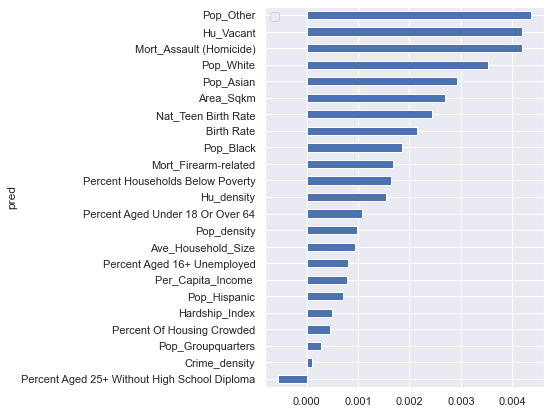

In [36]:
# Drop Column Importance - results are not comparable

dropcol_scores = []

for predictor in X.columns:
    rf_model_clone = clone(rf_model)
    rf_model_clone.random_state=1
    rf_model_clone.fit(X.drop(predictor, axis=1), y)
    dropcol_score = rf_model_clone.score(X.drop(predictor, axis=1), y)
    dropcol_scores.append({'pred': predictor,
                           'score': score_full_mod - dropcol_score})

dropcol_scores_df = (pd.DataFrame(dropcol_scores).
                     sort_values(by='score', ascending=False).set_index('pred'))
ax = dropcol_scores_df.plot(kind='barh', figsize=(5, 7))
ax.legend('')
ax.invert_yaxis()

Upon applying this method, vastly different results are seen compared to the previous feature importance methods used earlier. Further research explains how drop column importance is not appropriate for interpreting a fixed model, since unlike with permutation importance, a new model is created every time it is retrained on a dataset with less features. (Molnar, 2019) In the case of a Random Forest Model, entirely different decision trees would be created upon removing features, and so looking at drop column importance would mean comparing accuracies of vastly different forests. This becomes evident when different values for `random_state` are used, which results in wildly different drop column importance plots. We conclude that drop column importance is more appropriately used in during the feature engineering stage, or as a sensitivity analysis tool, rather than for model interpretability upon deployment.

#### Local Interpretability

Local interpretability was already touched upon in previous methods, for instance the summary plots above use the individual SHAP values and prediction lines for individual communities and combine them on one plot to provide insight on overall model behavior. Here we take a deeper look at local intepretability methods, to explain how predictions are arrived at for specific instances in the dataset.

Specifically, we examine two neighborhoods: Englewood and Norwood Park. These are the two communities  with the lowest and highest trust in police, with scores of 47.999 and 75.265, respectively.

In [37]:
pd.concat([df_targets.iloc[[67, 9]][['Trust_Score']], df_all.iloc[[67, 9]]], axis=1)

,Trust_Score,Area_Sqkm,Percent Of Housing Crowded,Percent Households Below Poverty,Percent Aged 16+ Unemployed,Percent Aged 25+ Without High School Diploma,Percent Aged Under 18 Or Over 64,Per_Capita_Income,Hardship_Index,Crime_density,...,Pop_Asian,Pop_Other,Hu_Vacant,Ave_Household_Size,Pop_density,Hu_density,Birth Rate,Nat_Teen Birth Rate,Mort_Assault (Homicide),Mort_Firearm-related
68 - Englewood,47.999,7.95,3.8,46.6,28.0,28.5,42.5,11888,94,0.21117,...,0.001108,0.025319,0.239902,2.520892,3065.283019,1588.176101,20.0,105.3,45.1,44.9
10 - Norwood Park,75.265,11.32,2.0,5.4,9.0,11.5,39.5,32875,21,0.02676,...,0.058011,0.032974,0.044403,2.472949,3383.657244,1416.519435,10.4,3.4,4.7,8.7


We start with Individual Conditional Expectation (ICE) plots, which are the local equivalent of the PDP plots constructed above. For the two communities, the same trends are observed are observed as compared with the PDP plots. Trust in police scores goes down in relation to worsening socio-economic conditions and higher proportions of the black population, while the reverse is true for high proportions of the white population.

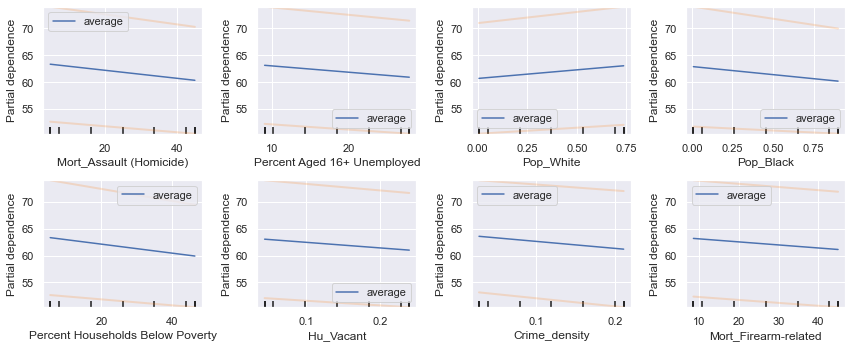

In [38]:
features = ['Mort_Assault (Homicide)', 'Percent Aged 16+ Unemployed',
            'Pop_White', 'Pop_Black', 'Percent Households Below Poverty',
            'Hu_Vacant', 'Crime_density', 'Mort_Firearm-related']

fig, ax = plt.subplots(2, 4, figsize=(12, 5))

for idx, feature_name in enumerate(features):
    display = PartialDependenceDisplay.from_estimator(
        estimator=rf_model,          # Estimator to be used
        X=X.iloc[[67, 9]],           # Data to be used for interpretation
        features=[feature_name],     # Feature list to be inspected
        feature_names=feature_names, # Feature names in the data
        kind="both",                 # kind='average' refers to PDP
        n_jobs=-1,                   # Number of CPU to compute the PDP in parallel
        grid_resolution=20,          # Number of points to be used in setting the
                                     #     feature of interest
        random_state=1,              # Set random state for reproducibility
        subsample=50,                # Number of subsample ICE to plot
        ice_lines_kw={               # Set the keyword arguments for the format of
            'color': 'tab:orange',   #     the ICE lines. Here, we set the color of
            'alpha': 0.20,           #     the lines to be orange, 0.20 opacity,
            'linewidth': 2,          #     and line width of 2 pts.
        },
        ax=ax[idx//4, idx%4]
)

plt.tight_layout()

In comparison with ICE, an elegant way of depicting the contributions of multiple features to the predictions on a single plot are through force plots, or waterfall plots. These are shown below, with the blue or "left-pointing" plots are for Englewood, and the red or "right-pointing" plots are for Norwood Park. These show how the different features push the prediction towards low and high values in the two neighborhoods, respectively.

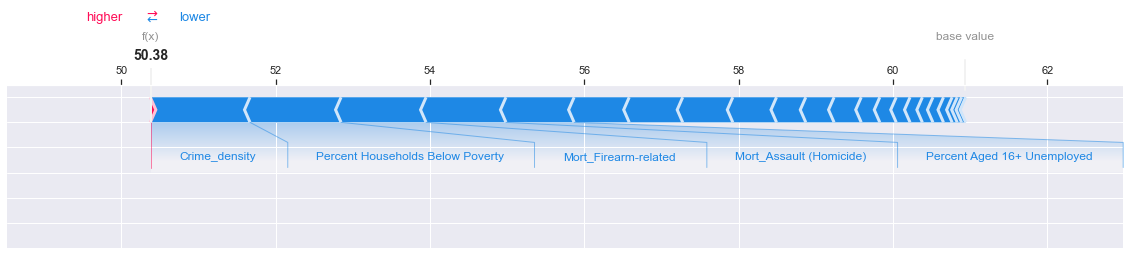

In [39]:
# Force Plot for Englewood
shap.force_plot(explainer.expected_value, 
                shap_values.values[67], feature_names, matplotlib=True)

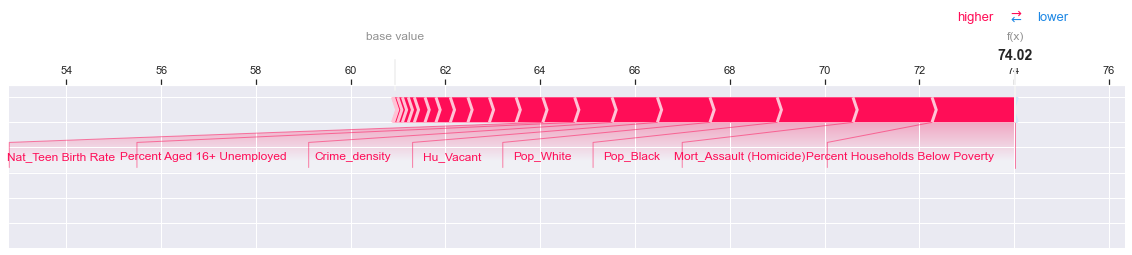

In [40]:
# Force Plot for Norwood Park
shap.force_plot(explainer.expected_value, 
                shap_values.values[9], feature_names, matplotlib=True)

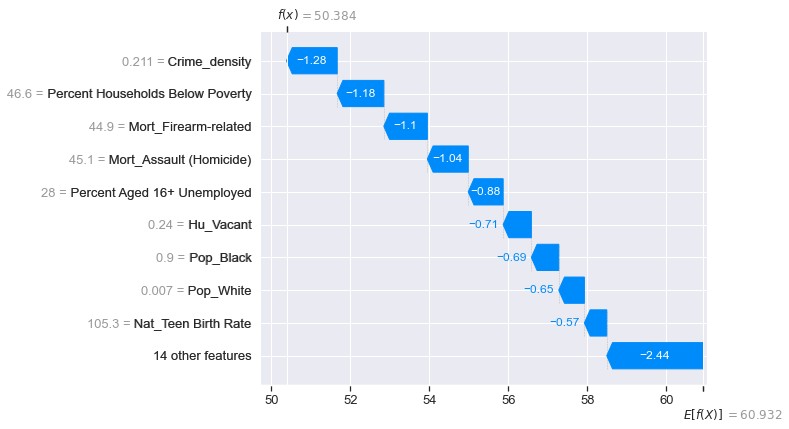

In [41]:
# Waterfall Plot for Englewood
shap.waterfall_plot(shap_values[67])

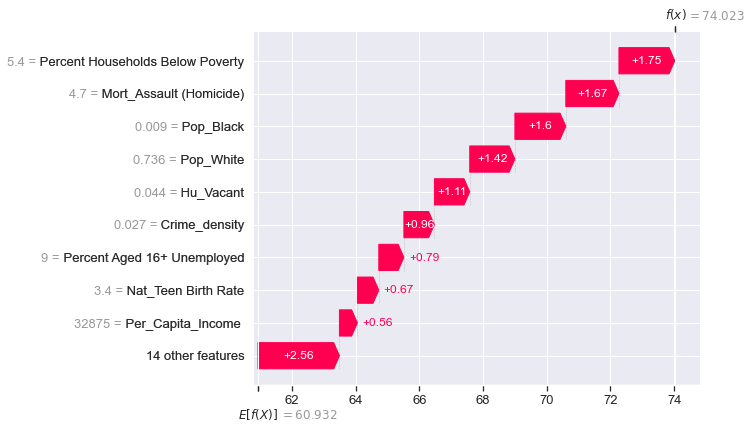

In [42]:
# Waterfall Plot for Norwood Park
shap.waterfall_plot(shap_values[9])

We see that high poverty and crime density contributed most strongly to the low police trust score of Englewood, while low poverty and homicide rates contributed most strongly to the high police trust score of Norwood Park.

### 6.2 Tree Interpreter

In [43]:
from sklearn import tree
from dtreeviz.trees import dtreeviz
from treeinterpreter import treeinterpreter as ti, utils
import waterfall_chart

dt_model = DecisionTreeRegressor(max_depth=3, random_state=1)
dt_model = dt_model.fit(X, y)

Looking back at the objective of this study, the idea was to open up the "black box" of a Random Forest model. One cannot help but compare Random Forests to individual decision trees, which are naturally interpretable--when considering a single tree, it is highly intuitive that predictions are made by traversing a path from the parent node, through a series of decisions "guarded" by particular features, towards a leaf. As a path on the decision tree is traversed, contributions are added to or subtracted from the base prediction to arrive at a specific final prediction.

For illustrative purposes, we show examples of a decision trees this dataset in two forms, one using inequalities and another using plots on the nodes, to depict the decision criteria.

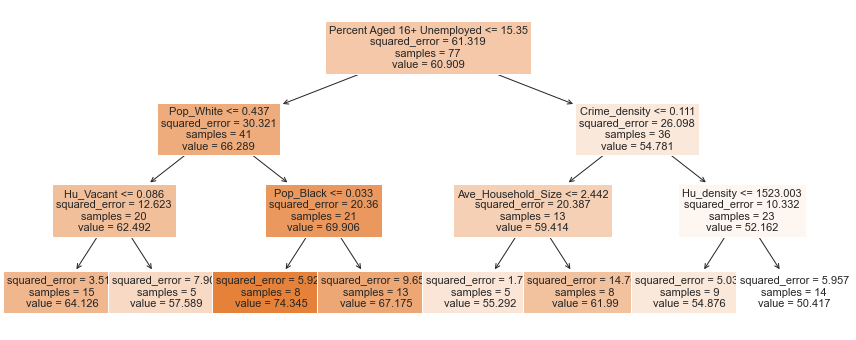

In [44]:
fig = plt.figure(figsize=(15,6))
tree.plot_tree(dt_model, feature_names=feature_names, filled=True, fontsize=11)
plt.show()

X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


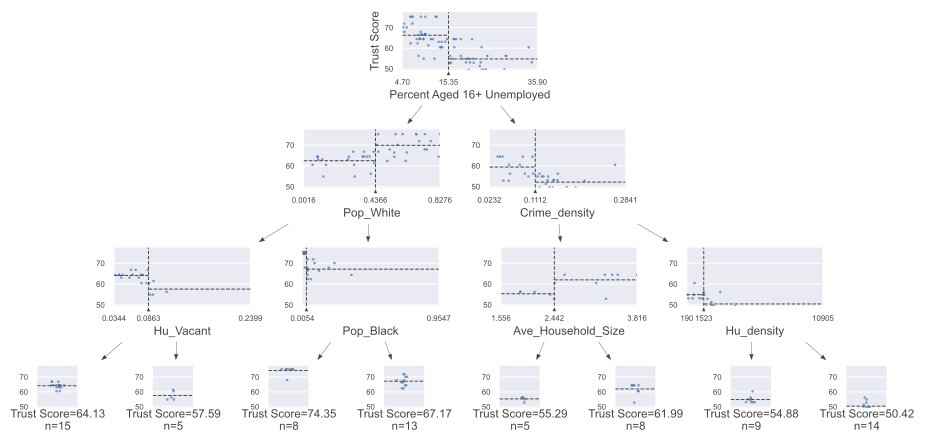

In [45]:
viz = dtreeviz(dt_model, X, y,
               target_name='Trust Score',
               feature_names=feature_names,
               orientation='TD', scale=1.3,
               show_root_edge_labels=False)

viz

Considering the above, it becomes apparent that the prediction function can be written in a form similar to a linear model, such that:

$f(x) = c_{full} + \sum\limits_{k=1}^K contrib(x, k)$

where:
- $K$ is the number of features
- $c_{full}$ is the base prediction value at the root or parent node
- $contrib(x,k)$ is the contribution from the $kth$ feature along the path or feature vector $x$

We also know that a random forest regressor makes predictions based on the average predictions of all its component trees, hence:

$F(x) = \frac{1}{J} \sum\limits_{j=1}^J f_j(x)$

where:

- $J$ is the number of trees in the forest

$f(x) = c_{full} + \sum\limits_{k=1}^K contrib(x, k)$

From here, it is simple to determine that the prediction of the random forest is simply average of the base predictions plus the average contribution of each feature:

$F(x) = \frac{1}{J}{\sum\limits_{j=1}^J {c_{j}}_{full}}  + \sum\limits_{k=1}^K (\frac{1}{J}\sum\limits_{j=1}^J contrib_j(x, k))$

All this may be used to provide an elegant way to come up with a way of ranking feature importance for a Random Forest model, by looking at these average contributions of each feature. This is therefore a useful global interpretability method that may be applied to Random Forest models. We make use of the `treeinterpreter` library (Saabas, 2014) to rank feature importances in a horizontal bar plot below. We are encouraged in this approach as the results are highly similar in terms of the top predictors (with only very minor variations) compared to those found earlier using impurity-based feature importance, permutation importance, and SHAP values.

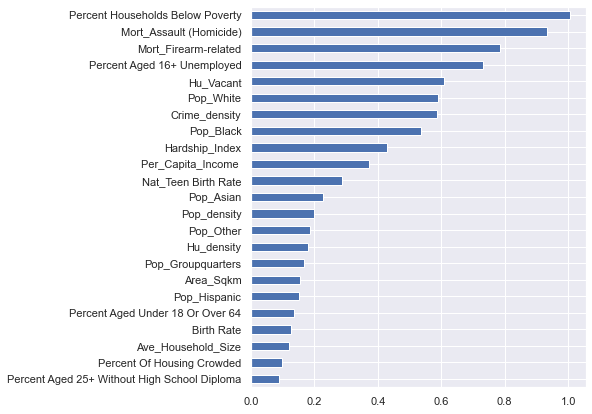

In [46]:
# Tree Interpreter, Global interpretability, Average absolute contributions for each Feature

pred_global, bias_global, contrib_global = ti.predict(rf_model, X.values)

df_contribs = pd.DataFrame(contrib_global, columns=feature_names, index=X.index)
df_contribs_ave = df_contribs.abs().mean(axis=0)

df_contribs_ave.sort_values(ascending=True).plot(kind='barh', figsize=(6, 7))
plt.show()

There is a limitation with this method however (and indeed with all model interpretability methods explored in preceding sections) when it comes to Random Forests. This method tends to isolate the contributions of individual features, similar to the coefficients of linear regression models, as previously mentioned. One may consider this as somewhat lacking when viewed specifically in the context of tree-based models.

For decision trees, predictions are not based strictly on the contributions of independent features. As mentioned, the concept of a decision tree is that predictions are made using a series of "if-then" questions, as represented by branching nodes on the tree. Such models therefore adopt the view that each node is conditional on the path previously taken, or on the answers given at previous nodes. Hence predictions are ultimately made based on interactions and dependencies between features. A satisfying interpretation for decision trees, and therefore for random forests, is one that would consider the joint contributions of different features.

Luckily, the `treeintepreter` library allows this, by providing an option to extract the joint contributions of different features. (Saabas, 2016) The downside is that given numerous randomly generated deep trees, it is possible to come up with thousands of different possible paths, as seen below when 2,321 paths were identified across all the trees in the random forest. Still, the method allows for the identification of paths that on average are strong predictors. In the plot below, 10 paths with the largest positive mean contributions and the 10 paths with the largest negative mean contributions are shown. The contributions may be seen regardless of whether the path happens to contain a single feature (e.g. `Per_Capita_Income`) or multiple features (`Pop_white` and `Pop_Black`).

Number of feature combinations:  2321


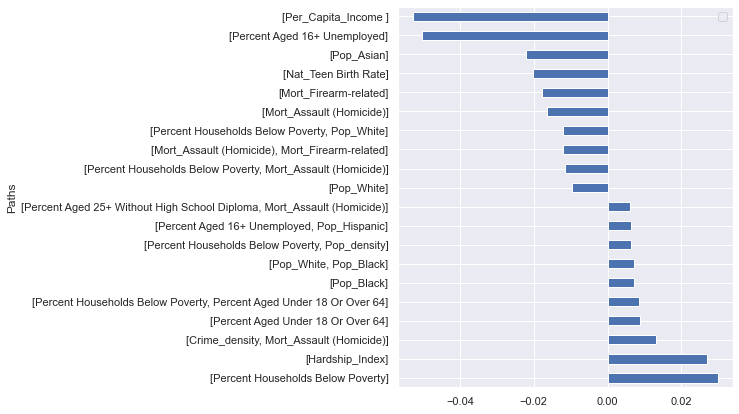

In [47]:
# Tree Interpreter, Global, Joint contributions for each Path
pred_joint, bias_joint, contrib_joint = ti.predict(rf_model, X.values, joint_contribution=True)
aggr_contrib = utils.aggregated_contribution(contrib_joint)

joint_contribs = []
for key, val in aggr_contrib.items():
    pred_list = [feature_names[i] for i in key]
    joint_contribs.append([pred_list, val[0]])

joint_contribs = (pd.DataFrame(joint_contribs, columns=['Paths', 'Contribution'])
                  .sort_values('Contribution', ascending=True)
                  .reset_index(drop=True).set_index('Paths'))

ax = joint_contribs.iloc[np.r_[:10, -10:0]].plot(kind='barh', figsize=(6, 7))
ax.legend('')
ax.invert_yaxis()

print('Number of feature combinations: ', len(joint_contribs))

### Tree Importance (Local)

The Tree Interpreter method also shines when used for local interpretability, since each instance corresponds to only one path on any given decision tree. Hence the average contributions of the features across the different paths traversed by that instance in the different trees in the forest can be used to explain how the model came up with a prediction for that instance.

These average contributions can be depicted using waterfall plots, in the same manner as individual SHAP values. Once again, we look at Englewood and Norwood Park as communities of interest. Initially, we do this without considering feature interactions and look at the contributions of lone features.

In [48]:
pd.concat([df_targets.iloc[[67, 9]][['Trust_Score']], df_all.iloc[[67, 9]]], axis=1)

,Trust_Score,Area_Sqkm,Percent Of Housing Crowded,Percent Households Below Poverty,Percent Aged 16+ Unemployed,Percent Aged 25+ Without High School Diploma,Percent Aged Under 18 Or Over 64,Per_Capita_Income,Hardship_Index,Crime_density,...,Pop_Asian,Pop_Other,Hu_Vacant,Ave_Household_Size,Pop_density,Hu_density,Birth Rate,Nat_Teen Birth Rate,Mort_Assault (Homicide),Mort_Firearm-related
68 - Englewood,47.999,7.95,3.8,46.6,28.0,28.5,42.5,11888,94,0.21117,...,0.001108,0.025319,0.239902,2.520892,3065.283019,1588.176101,20.0,105.3,45.1,44.9
10 - Norwood Park,75.265,11.32,2.0,5.4,9.0,11.5,39.5,32875,21,0.02676,...,0.058011,0.032974,0.044403,2.472949,3383.657244,1416.519435,10.4,3.4,4.7,8.7


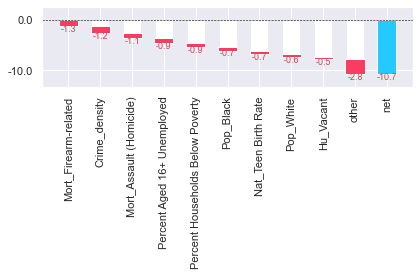

In [49]:
# Marginal contributions of lone features, without interactions
# Englewood

instances = X.iloc[[67]]
pred_local, bias_local, contrib_local = ti.predict(rf_model, instances.values)

contribs = [contrib_local[0][i] for i in range(len(contrib_local[0]))]

waterfall_chart.plot(feature_names, contribs,
                     rotation_value=90, sorted_value=True,
                     threshold=0.3)
plt.show()

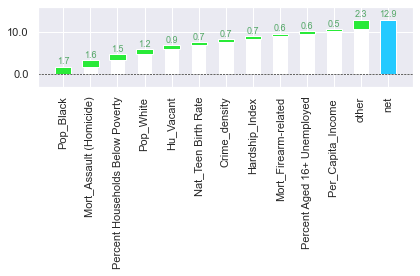

In [50]:
# Marginal contributions of lone features, without interactions
# Norwood Park

instances = X.iloc[[9]]
pred_local, bias_local, contrib_local = ti.predict(rf_model, instances.values)

contribs = [contrib_local[0][i] for i in range(len(contrib_local[0]))]

waterfall_chart.plot(feature_names, contribs,
                     rotation_value=90, sorted_value=True,
                     threshold=0.3)
plt.show()

We see that firearm deaths and crime density contributed most strongly to the low predicted police trust score of Englewood, while the black population and homicide rates contributed most strongly to the high predicted  trust score of Norwood Park.

Next, we avail of the option offered by the `treeinterpreter` library to extract the joint contributions of feature combinations for the two communities.

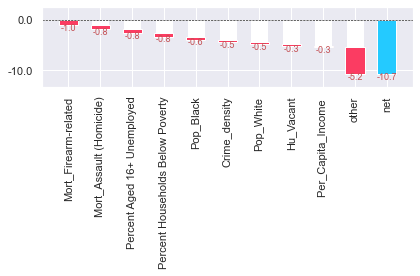

,Contribution
Paths,
[Mort_Firearm-related],-0.981614
[Mort_Assault (Homicide)],-0.805818
[Percent Aged 16+ Unemployed],-0.788044
[Percent Households Below Poverty],-0.783304
[Pop_Black],-0.585894
...,...
"[Per_Capita_Income , Hardship_Index, Crime_density, Pop_White, Hu_Vacant]",0.047200
"[Percent Households Below Poverty, Percent Aged 16+ Unemployed, Pop_Groupquarters, Pop_Other, Nat_Teen Birth Rate]",0.049660
"[Hardship_Index, Hu_Vacant, Pop_density, Mort_Firearm-related]",0.057254


In [51]:
# Joint contributions of each path, including interactions
# Englewood

instances = X.iloc[[67]]
pred_joint, bias_joint, contrib_joint = ti.predict(rf_model, instances.values, joint_contribution=True)
aggr_contrib = utils.aggregated_contribution(contrib_joint)

joint_contribs = []
for key, val in aggr_contrib.items():
    pred_list = [feature_names[i] for i in key]
    joint_contribs.append([pred_list, val[0]])

joint_contribs = (pd.DataFrame(joint_contribs, columns=['Paths', 'Contribution'])
                  .sort_values('Contribution')
                  .reset_index(drop=True).set_index('Paths'))
waterfall_chart.plot([', '.join(i) for i in list(joint_contribs.index)],
                     joint_contribs['Contribution'].to_list(),
                     rotation_value=90, sorted_value=True,
                     threshold=0.3)
plt.show()
joint_contribs

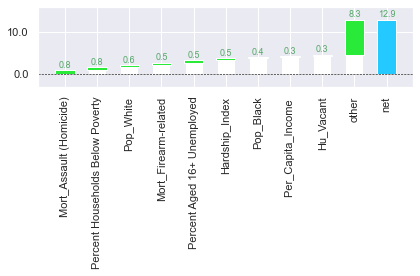

,Contribution
Paths,
[Mort_Assault (Homicide)],0.794125
[Percent Households Below Poverty],0.769954
[Pop_White],0.583119
[Mort_Firearm-related],0.525672
[Percent Aged 16+ Unemployed],0.512026
...,...
"[Percent Aged Under 18 Or Over 64, Hu_Vacant]",-0.023214
"[Percent Aged 16+ Unemployed, Pop_Groupquarters, Pop_White]",-0.024076
"[Percent Households Below Poverty, Pop_Groupquarters, Pop_Other, Mort_Assault (Homicide), Mort_Firearm-related]",-0.038221


In [52]:
# Joint contributions of each path, including interactions
# Norwood Park

instances = X.iloc[[9]]
pred_joint, bias_joint, contrib_joint = ti.predict(rf_model, instances.values, joint_contribution=True)
aggr_contrib = utils.aggregated_contribution(contrib_joint)

joint_contribs = []
for key, val in aggr_contrib.items():
    pred_list = [feature_names[i] for i in key]
    joint_contribs.append([pred_list, val[0]])

joint_contribs = (pd.DataFrame(joint_contribs, columns=['Paths', 'Contribution'])
                  .sort_values('Contribution', ascending=False)
                  .reset_index(drop=True).set_index('Paths'))
waterfall_chart.plot([', '.join(i) for i in list(joint_contribs.index)],
                     joint_contribs['Contribution'].to_list(),
                     rotation_value=90, sorted_value=True,
                     threshold=0.3)
plt.show()
joint_contribs

Interestingly, feature combinations were not among the top predictors for the police trust scores of either Englewood or Norwood Park. This is not counter-intuitive, since a strong predictor may be sufficient in a decision tree to yield a prediction, without the need for further branching nodes. Regardless, we see that firearm and homicide deaths as lone features are the most significant predictors for Englewood, while homicide deaths and poverty are the top predictors for Norwood Park.  

### **6.0 Results and Discussion**

In general, the strong agreement between the different model interpretation methods gives us confidence in our interpretation of the Random Forest Model. While the different methods differ slightly in ranking, they allow us to identify the top predictors of police sentiment scores.

Generally, we see that the following predictors contribute negatively to police sentiment scores (i.e. high values of these features leads to lower-valued predictions, and vice versa):

- Mortality rates due to homicide
- Mortality rates from firearms
- Crime density
- Percentage of households below poverty
- Percentage of adults unemployed
- Percentage of the population that are black
- Proportion of housing units that are vacant

Meanwhile, the following predictor contributes positively to police sentiment scores (high values lead to high trust scores, and vice versa):

- Percentage of the population that are white

Local interpretability methods allow us to see the role these variables play in predicting trust scores of specific communities. Meanwhile, the Tree Interpreter method allows us to look at the contributions of features in combination with one another, whether in a global or local scope.

A clear takeaway from the model interpretability methods is that the incidence of violent deaths and crime,  socio-economic levels, and race all play a significant role in whether a community trusts their law enforcement. It is hoped that these results provide a coherent story for the model to be accepted by stakeholders, in their decision to adopt the model to predict, and therefore manage, public perceptions of police trustworthiness.

### **7.0 Conclusions and Areas for Further Study**

Here, we recap some of the key approaches and insights adopted in the course of this model interpretability study.

- Different feature importance methods can be used side by side when intepreting a model. When the results largely agree, this can help greatly for improving confidence in the model, and thus its acceptance by decision-makers. Useful methods include Gini importance, permutation importance, or average SHAP values.
- However, drop column importance is flawed as a model interpretability technique, if the goal is to interpret a fixed model.
- SHAP is a highly flexible technique, especially with the different plotting methods available in the `shap` library. It can be used to show the distributions of SHAP values across features and instances to suit the analyst's purpose.
- Partial dependence plots, SHAP dependence plots, and ICE can all be used to depict the relationships of specific features with respect to the target variable. Hence these are very useful when one wants to take a closer look at the identified top predictors.
- Local interpretability methods, particularly force plots and waterfall plots, are useful when we wish to explain specific predictions, or understand what is happening in particular communities. 
- The Tree Interpreter method allows us to look at the contributions of features either independently or in combination with one another. It is highly useful in unpacking a Random Forest model, although once must be prepared to consider numerous possible feature interactions.
- Tree Interpreter can also be used for both global and local interpretability.

Possible future approaches might be to apply these model interpretability techniques to the Random Forest model trained using alternative feature sets, or on other regressor models. For instance the Gradient Boosting Method (GBM), was found to have high accuracy, so research might be conducted on whether there is an equivalent of the Tree Interpreter method that may be applied to GBM. It would also be fruitful to re-train and re-interpret models using a larger sample size, if similar data can be obtained for other communities in the US and other countries. or in other time periods.

### References

*Badeer, P. (2020). Feature Importance May be Lying to You. Towards Data Science. https://towardsdatascience.com/feature-importance-may-be-lying-to-you-3247cafa7ee7*

*Lewinson, E. (2019). Explaining Feature Importance by example of a Random Forest. Towards Data Science.
https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e*

*Molnar, C. (2019) Interpretable machine learning: A Guide for Making Black Box Models Explainable. https://christophm.github.io/interpretable-ml-book/.*

*Saabas, A. (2014). Interpreting random forests. Diving Into Data. http://blog.datadive.net/interpreting-random-forests/*

*Saabas, A. (2016). Random forest interpretation – conditional feature contributions. Diving Into Data. http://blog.datadive.net/random-forest-interpretation-conditional-feature-contributions/*